##Visualizations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
df_values = pd.read_csv("clean_training_set_values.csv")
df_labels = pd.read_csv("training_set_labels.csv")

In [6]:
#merge the features (i.e. values) and the labels into one DataFrame
df = pd.merge(df_values, df_labels, on="id")

#Exploratory analysis

##Categorical Features

We have the following categorical variables:
- funder
- installer
- basin
- subvillage
- region
- scheme_management
- management
- management_group
- public_meeting (T/F)
- permit (T/F)
- extraction_type
- extraction_type_group
- extraction_type_class
- payment
- payment_type
- water_quality
- quality_group
- waterpoint_type
- waterpoint_type_group

###Mapping the Data

First, we create maps of the data to determine whether there are any strong links between any of the features and the status of the wells. We used matplotlib's basemap feature to provide the map and plotted each well using the latitude and longitude values, coloring on different features. 

In [83]:
from mpl_toolkits.basemap import Basemap

# adapated from http://matplotlib.org/basemap/users/examples.html

def mapwell(df, category, use_colors = False, cmap = False, ax = False, lat_0=-6,lon_0=34,llcrnrlon=28, llcrnrlat=-12,
                urcrnrlon=41, urcrnrlat=0):
    
    # setup cylindrical basemap.
    m = Basemap(projection='cyl',
                resolution='h',
                lat_0=lat_0,lon_0=lon_0, 
                llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, 
                ax=ax)

    # draw coastlines.
    m.drawcoastlines()

    # draw countries borders.
    m.drawcountries()

    # draw a boundary around the map, fill the background.
    # this background will end up being the ocean color, since
    # the continents will be drawn on top.
    m.drawmapboundary(fill_color='aqua')

    # fill continents, set lake color same as ocean color.
    m.fillcontinents(color='white',lake_color='aqua', zorder = 0)

    # create scatter plot
    if use_colors:
        m.scatter(df.longitude.values, df.latitude.values, marker = 'o',zorder = 1, latlon=True, alpha = 0.05, 
                  c=[use_colors[x] for x in category],s=30,lw=0)
    if cmap: 
        tot = float(len(pd.Series(category.ravel()).unique()))
        print pd.Series(category.ravel()).unique()
        use_colors2 = {}
        for index,x in enumerate(pd.Series(category.ravel()).unique()):
            use_colors2[x] = cmap(float(index)/tot) 
    
        m.scatter(df.longitude.values, df.latitude.values, marker = 'o',zorder = 1, latlon=True, alpha = 0.05, 
                   c=[use_colors2[x] for x in category],s=30,lw=0)

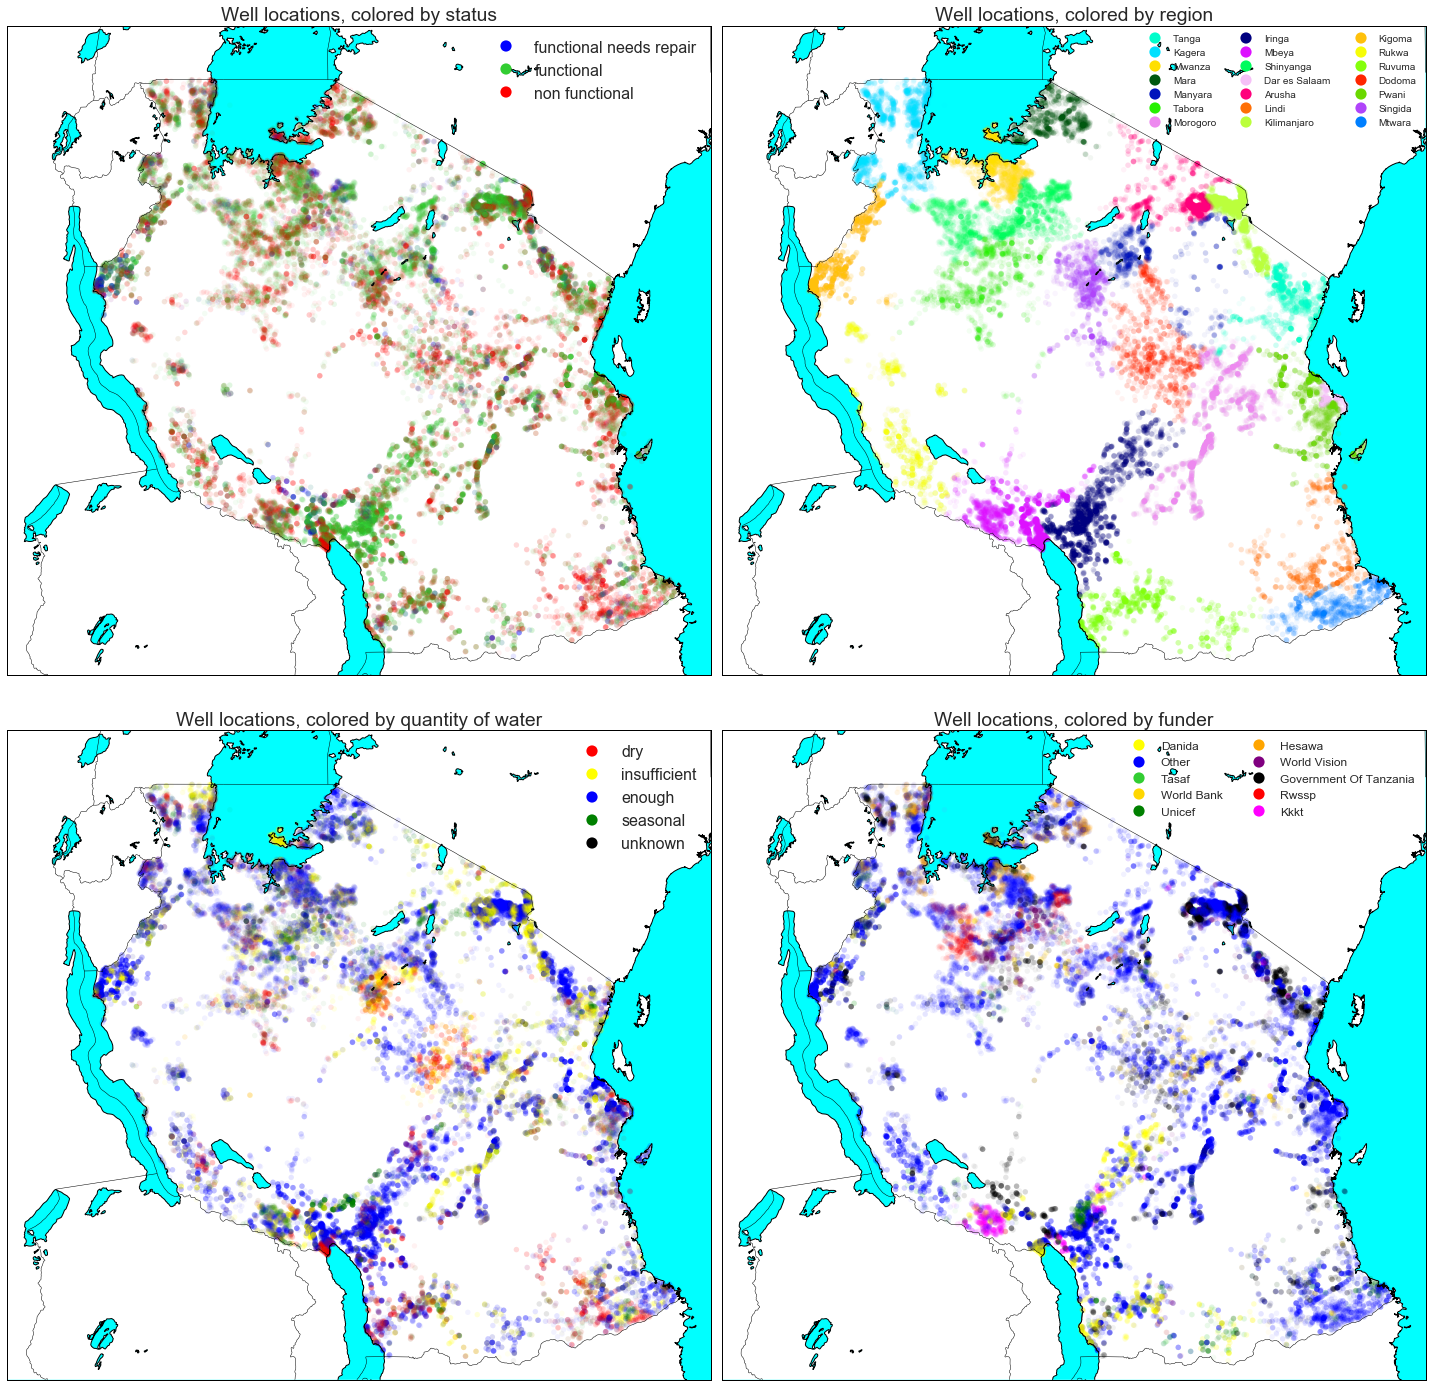

In [46]:
# create plot
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(20, 20),tight_layout = True)

# status map
use_colors = {"functional": "limegreen", "non functional": "red", "functional needs repair": "blue"}
mapwell(df, df.status_group, use_colors = use_colors, ax = ax1)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors.values()]
ax1.legend(markers, use_colors.keys(), numpoints=1)
ax1.set_title("Well locations, colored by status")

# regional wells map
import matplotlib.cm as cm
mapwell(df, df.region, cmap = cm.gist_ncar, ax = ax2)
ax2.set_title("Well locations, colored by region")
tot = float(len(pd.Series(df.region.ravel()).unique()))
use_colors2 = {}
for index,x in enumerate(pd.Series(df.region.ravel()).unique()):
    use_colors2[x] = cm.gist_ncar(float(index)/tot) 
markers2 = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors2.values()]
ax2.legend(markers2, use_colors2.keys(), numpoints=1, ncol=3, fontsize=10)

# water quantity map
use_colors3 = {"enough": "blue", "insufficient": "yellow", "dry": "red", "seasonal": "green", "unknown": "black"}
markers3 = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors3.values()]
mapwell(df, df.quantity, use_colors = use_colors3, ax = ax3)
ax3.set_title("Well locations, colored by quantity of water")
ax3.legend(markers3, use_colors3.keys(), numpoints=1)

# funder map
use_colors4 = {'Other':'blue', 'Unicef':'green', 'Rwssp':'red', 'Danida':'yellow', 'World Vision':'purple', 'Hesawa':'orange', 
               'Government Of Tanzania':'black', 'Kkkt':'magenta', 'Tasaf':'limegreen', 'World Bank':'gold'}
markers4 = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors4.values()]
ax4.legend(markers4,use_colors4.keys(),numpoints=1, loc=1, ncol=2, fontsize=12)
mapwell(df[[~x for x in df.funder.isnull()]], df.funder[[~x for x in df.funder.isnull()]], use_colors = use_colors4, ax = ax4)
ax4.set_title("Well locations, colored by funder")

plt.show()

Connections:
-Iringa has a lot of functional wells, Mtwara and Kigoma have a lot of non functional wells
-A lot of the wells that are non functional are dry
-Hard to see connection between funder and well status

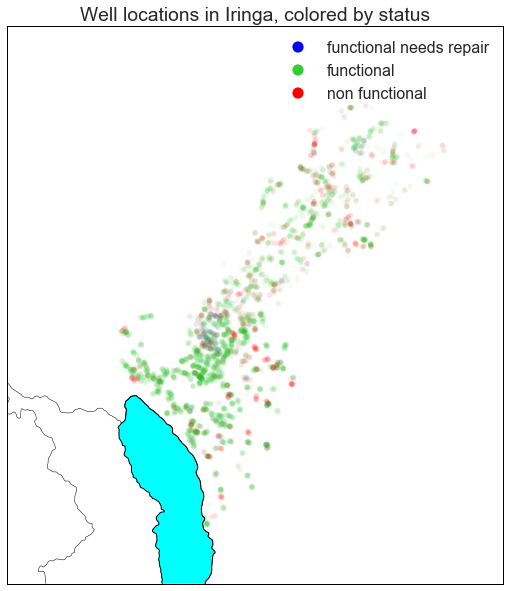

In [88]:
fig,ax1 = plt.subplots(1, figsize=(10,10))
mapwell(df[df.region == 'Iringa'],df[df.region.values == 'Iringa'].status_group, use_colors, ax=ax1, llcrnrlon=33, llcrnrlat=-11,
                urcrnrlon=37, urcrnrlat=-6.5)
ax1.legend(markers, use_colors.keys(), numpoints=1,loc='best')
ax1.set_title("Well locations in Iringa, colored by status")

###Redundancies
We see that some of the columns describe the same feature but have slightly different sets of values. This is particularly the case with features that also have a corresponding '_ _group_' column as well. For now, we will stick with the non-group features because they are more specific.

In [7]:
print pd.Series(df.extraction_type.ravel()).unique()
#less specific
print pd.Series(df.extraction_type_group.ravel()).unique()
print pd.Series(df.extraction_type_class.ravel()).unique()

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi']
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [8]:
#equivalent
print pd.Series(df.payment.ravel()).unique()
print pd.Series(df.payment_type.ravel()).unique()

['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']


In [9]:
#the difference here is the addition of 'communal standpipe multiple' in waterpoint_type
print pd.Series(df.waterpoint_type.ravel()).unique()
#less specific
print pd.Series(df.waterpoint_type_group.ravel()).unique()

['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
['communal standpipe' 'hand pump' 'other' 'improved spring' 'cattle trough'
 'dam']


In [10]:
print pd.Series(df.water_quality.ravel()).unique()
#less specific
print pd.Series(df.quality_group.ravel()).unique()

['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']


In [11]:
#less specific
#'borehole' includes 'machine dbh' and 'hand dtw'
#'river/lake' includes 'river' and 'lake'
#'other' includes 'other' and 'unknown'
print pd.Series(df.source_type.ravel()).unique()
print pd.Series(df.source.values.ravel()).unique()
#source and source_type are nested within source_class
print pd.Series(df.source_class.values.ravel()).unique()

['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other' 'shallow well'
 'river' 'hand dtw' 'lake' 'unknown']
['groundwater' 'surface' 'unknown']


In [12]:
#management is nested within management_group
print pd.Series(df.management.ravel()).unique()
print pd.Series(df.management_group.ravel()).unique()

['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
['user-group' 'other' 'commercial' 'parastatal' 'unknown']


In [33]:
df_new1 = df.drop(['quantity_group','extraction_type_group','waterpoint_type_group','quality_group','source_type',
                   'payment', 'construction_year','latitude','longitude', 'subvillage','id'], axis=1)
df_new = df.drop(['quantity_group','extraction_type','waterpoint_type','quality_group','source','payment', 
                  'construction_year','subvillage','id'], axis=1)

In [14]:
df_new.head()

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,...,management_group,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,6000,Other,1390,Other,Lake Nyasa,Iringa,109,True,VWC,False,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1024,Mar,functional
1,0,Other,1399,Other,Lake Victoria,Mara,280,NaN,Other,True,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,301,Mar,functional
2,25,Other,686,Other,Pangani,Manyara,250,True,VWC,True,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe,310,Feb,functional
3,0,Unicef,263,Other,Ruvuma / Southern Coast,Mtwara,58,True,VWC,True,...,user-group,never pay,soft,dry,borehole,groundwater,communal standpipe,338,Jan,non functional
4,0,Other,0,Other,Lake Victoria,Kagera,0,True,NaN,True,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,903,Jul,functional


###Nestings

In df_new, we know that:
- management is nested within management_group
- source is nested within source_class
- extraction is nested within extraction_type_class
- subvillage is nested within region

###Grouping the types of categorical variables
The features dealing with the management of the well include:
- funder
- installer
- scheme_management
- management/management_group
- payment_type
- permit (T/F)

The features dealing with the creation of the well include:
- extraction/extraction_type_class
- waterpoint_type

The features dealing with time include: 
- construction_year
- date_recorded_offset_days (int; how long ago it was constructed, from the date recorded)
- date_recorded_month

The features dealing with natural properties include:
- water_quality
- source/source_class
- amount_tsh
- quantity
- basin

The features dealing with the community using the well and location include:
- subvillage
- region
- population
- public_meeting (T/F)
- gps_height
- longitude
- latitude

In [17]:
df_new.columns

Index([u'amount_tsh', u'funder', u'gps_height', u'installer', u'basin',
       u'region', u'population', u'public_meeting', u'scheme_management',
       u'permit', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment_type', u'water_quality',
       u'quantity', u'source_type', u'source_class', u'waterpoint_type_group',
       u'date_recorded_offset_days', u'date_recorded_month', u'status_group'],
      dtype='object')

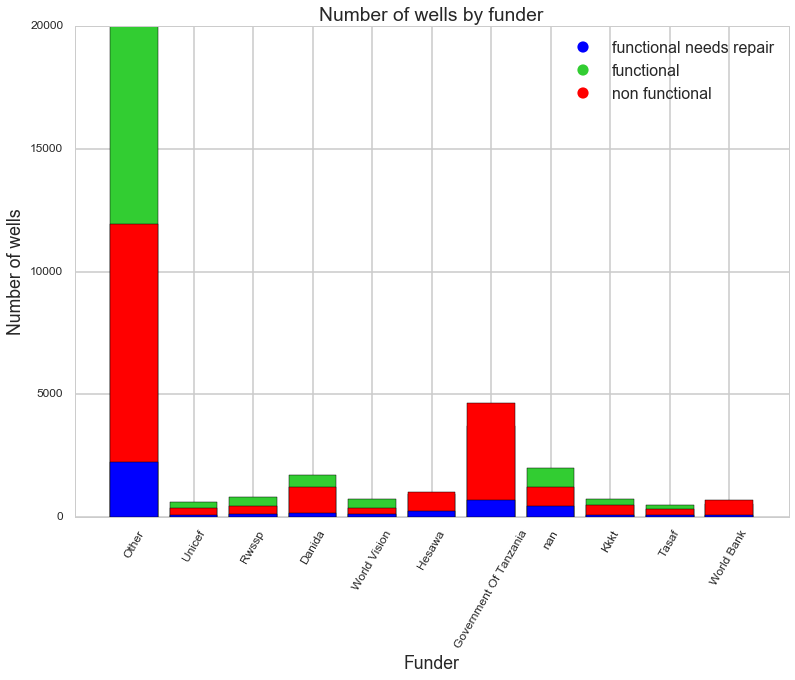

In [116]:
#for funders
functional = df_new[df_new['status_group']=='functional']['funder'].tolist()
non_functional = df_new[df_new['status_group']=='non functional']['funder'].tolist()
needs_repair = df_new[df_new['status_group']=='functional needs repair']['funder'].tolist()

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

categories = pd.Series(df_new.funder.values.ravel()).unique()
value_freq_funct = []
value_freq_nonf = []
value_freq_repair = []
categories_num = range(1,len(categories)+1)
for value in categories:
    value_freq_funct.append(functional.count(value))
    value_freq_nonf.append(non_functional.count(value))
    value_freq_repair.append(needs_repair.count(value))
fig.set_size_inches(8, 5)
plt.bar(categories_num,value_freq_funct,align='center',color='limegreen')
plt.bar(categories_num,value_freq_nonf,align='center',color='r')
plt.bar(categories_num,value_freq_repair,align='center',color='b')
plt.xticks(categories_num, categories, rotation = 60)
plt.legend(markers,use_colors.keys())
plt.ylabel("Number of wells")
plt.xlabel("Funder")
plt.title("Number of wells by funder")

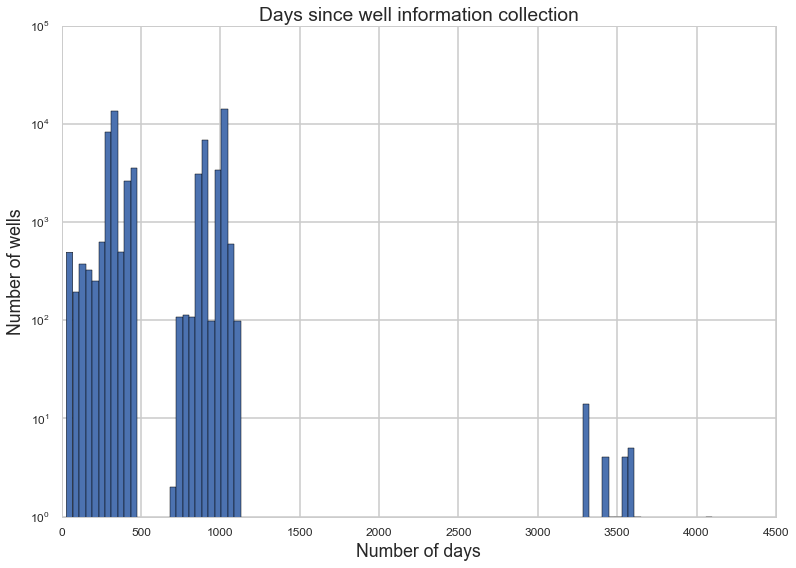

In [110]:
plt.hist(df_new.date_recorded_offset_days,bins=100,log=True)
plt.title("Days since well information collection")

plt.xlabel("Number of days")
plt.ylabel("Number of wells")

##Split into Testing and Training

In [117]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(xrange(df_new.shape[0]), train_size=0.7)
mask=np.ones(df_new.shape[0])
mask[train]=1
mask[test]=0
mask = (mask==1)

##Standardize

In [119]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(xrange(df_new.shape[0]), train_size=0.7)
mask=np.ones(df_new.shape[0])
mask[train]=1
mask[test]=0
mask = (mask==1)

In [121]:
from sklearn import preprocessing as prepr
STANDARDIZABLE = [u'amount_tsh', u'gps_height', u'population', u'date_recorded_offset_days']
scaler = prepr.StandardScaler().fit(df_new[mask][STANDARDIZABLE])
df_new[STANDARDIZABLE] = scaler.transform(df_new[STANDARDIZABLE])
df_new[STANDARDIZABLE].head()

,amount_tsh,gps_height,population,date_recorded_offset_days
0,1.844989,1.044030,-0.149624,1.139392
1,-0.103563,1.057029,0.201392,-1.020516
2,-0.095444,0.027212,0.139810,-0.993629
3,-0.103563,-0.583746,-0.254313,-0.909981
4,-0.103563,-0.963608,-0.373371,0.777913


Do any of the variables in STANDARDIZABLE seem like useful indicators for well status?

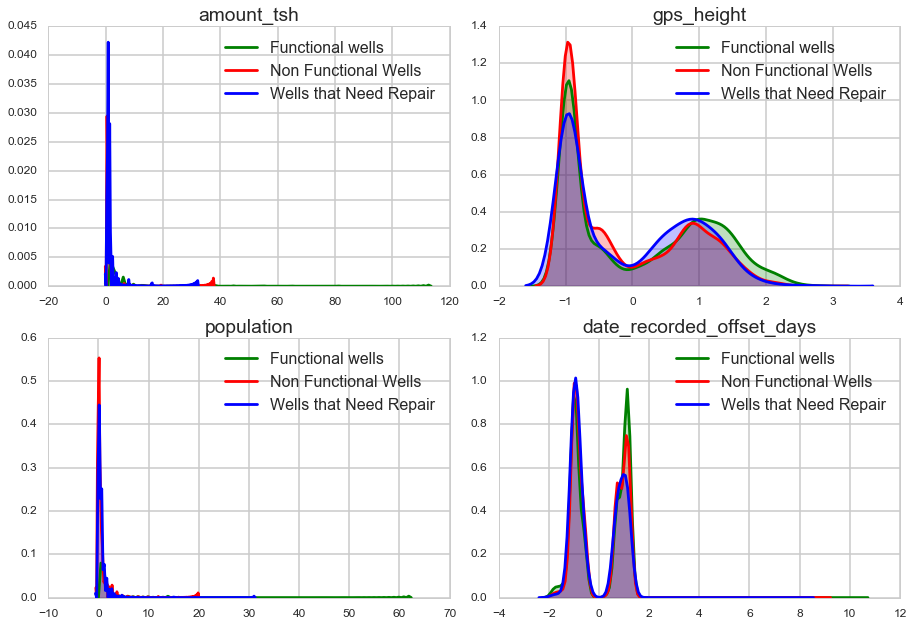

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=2)

for i, feature in enumerate(STANDARDIZABLE):
    ax = axes[i/2, i%2]
    sns.kdeplot(df_new[df_new['status_group']=='functional'][feature], ax=ax, shade=True,color='limegreen', label="Functional wells")
    sns.kdeplot(df_new[df_new['status_group']=='non functional'][feature], ax=ax, shade=True,color='red', label="Non Functional Wells")
    sns.kdeplot(df_new[df_new['status_group']=='functional needs repair'][feature], ax=ax, shade=True,color='blue', label="Wells that Need Repair")
    ax.set_title(feature)

fig.tight_layout()

##Categorical

In [123]:
CATEGORICAL = [u'funder', u'installer', u'basin', u'region',
               u'public_meeting', u'scheme_management', u'permit',
               u'extraction_type_group', u'extraction_type_class',
               u'management', u'management_group', u'payment_type', u'water_quality',
               u'quantity', u'source_type', u'source_class', u'waterpoint_type_group', u'date_recorded_month']
for variable in CATEGORICAL:
    df_new[variable] = df_new[variable].astype('category')  

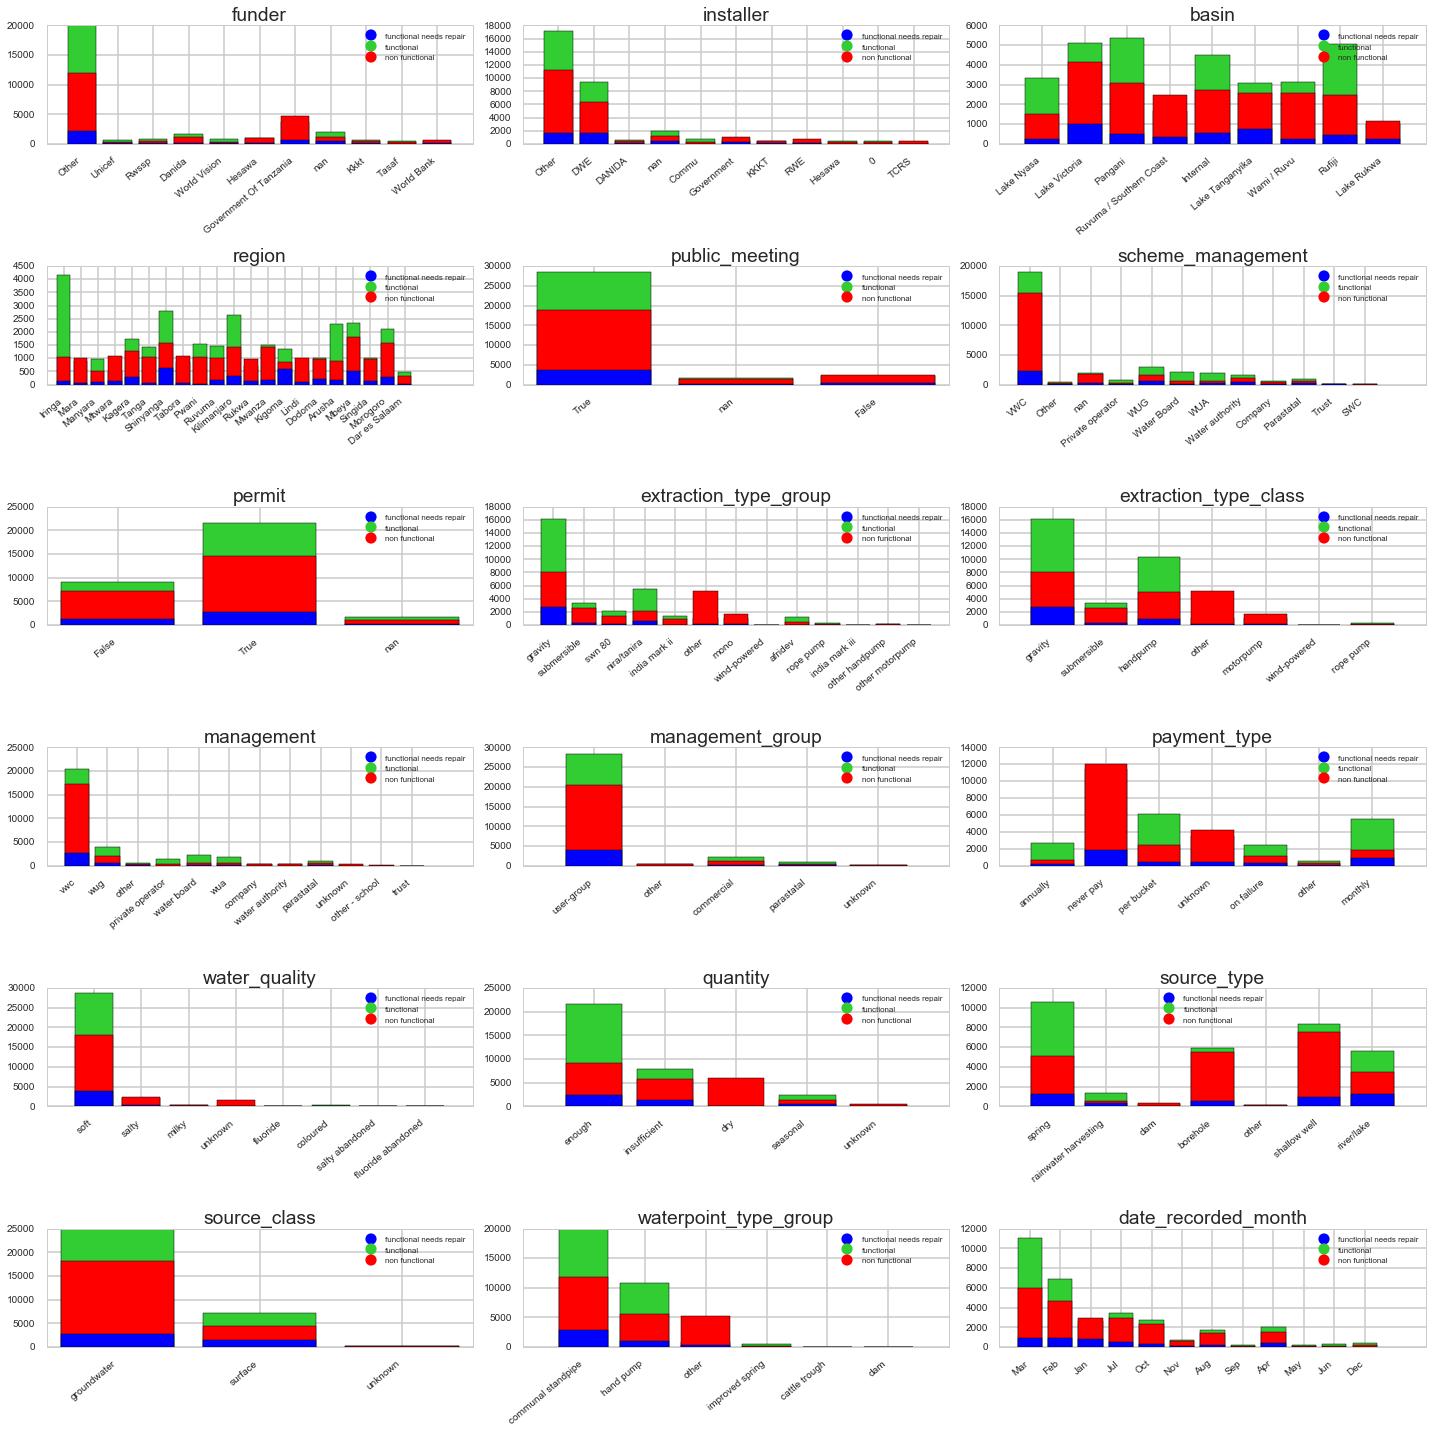

In [173]:
fig1, axes1 = plt.subplots(6,3,tight_layout=True,figsize=(20,20))

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for j, variable in enumerate(CATEGORICAL):
    ax1 = axes1[j/3,j%3]
    functional = df_new[df_new['status_group']=='functional'][variable].tolist()
    non_functional = df_new[df_new['status_group']=='non functional'][variable].tolist()
    needs_repair = df_new[df_new['status_group']=='functional needs repair'][variable].tolist()
    categories = pd.Series(df_new[variable].values.ravel()).unique()
    value_freq_funct = []
    value_freq_nonf = []
    value_freq_repair = []
    categories_num = range(1,len(categories)+1)
    for value in categories:
        value_freq_funct.append(functional.count(value))
        value_freq_nonf.append(non_functional.count(value))
        value_freq_repair.append(needs_repair.count(value))
    ax1.bar(categories_num,value_freq_funct,align='center',color='limegreen')
    ax1.bar(categories_num,value_freq_nonf,align='center',color='r')
    ax1.bar(categories_num,value_freq_repair,align='center',color='b')
    ax1.set_xticks(categories_num)
    ax1.set_xticklabels(categories,ha='right',rotation=40)
    ax1.legend(markers,use_colors.keys(),loc='best',fontsize='8')
    ax1.set_title(variable)

plt.show()

TypeError: 'NoneType' object is not iterable

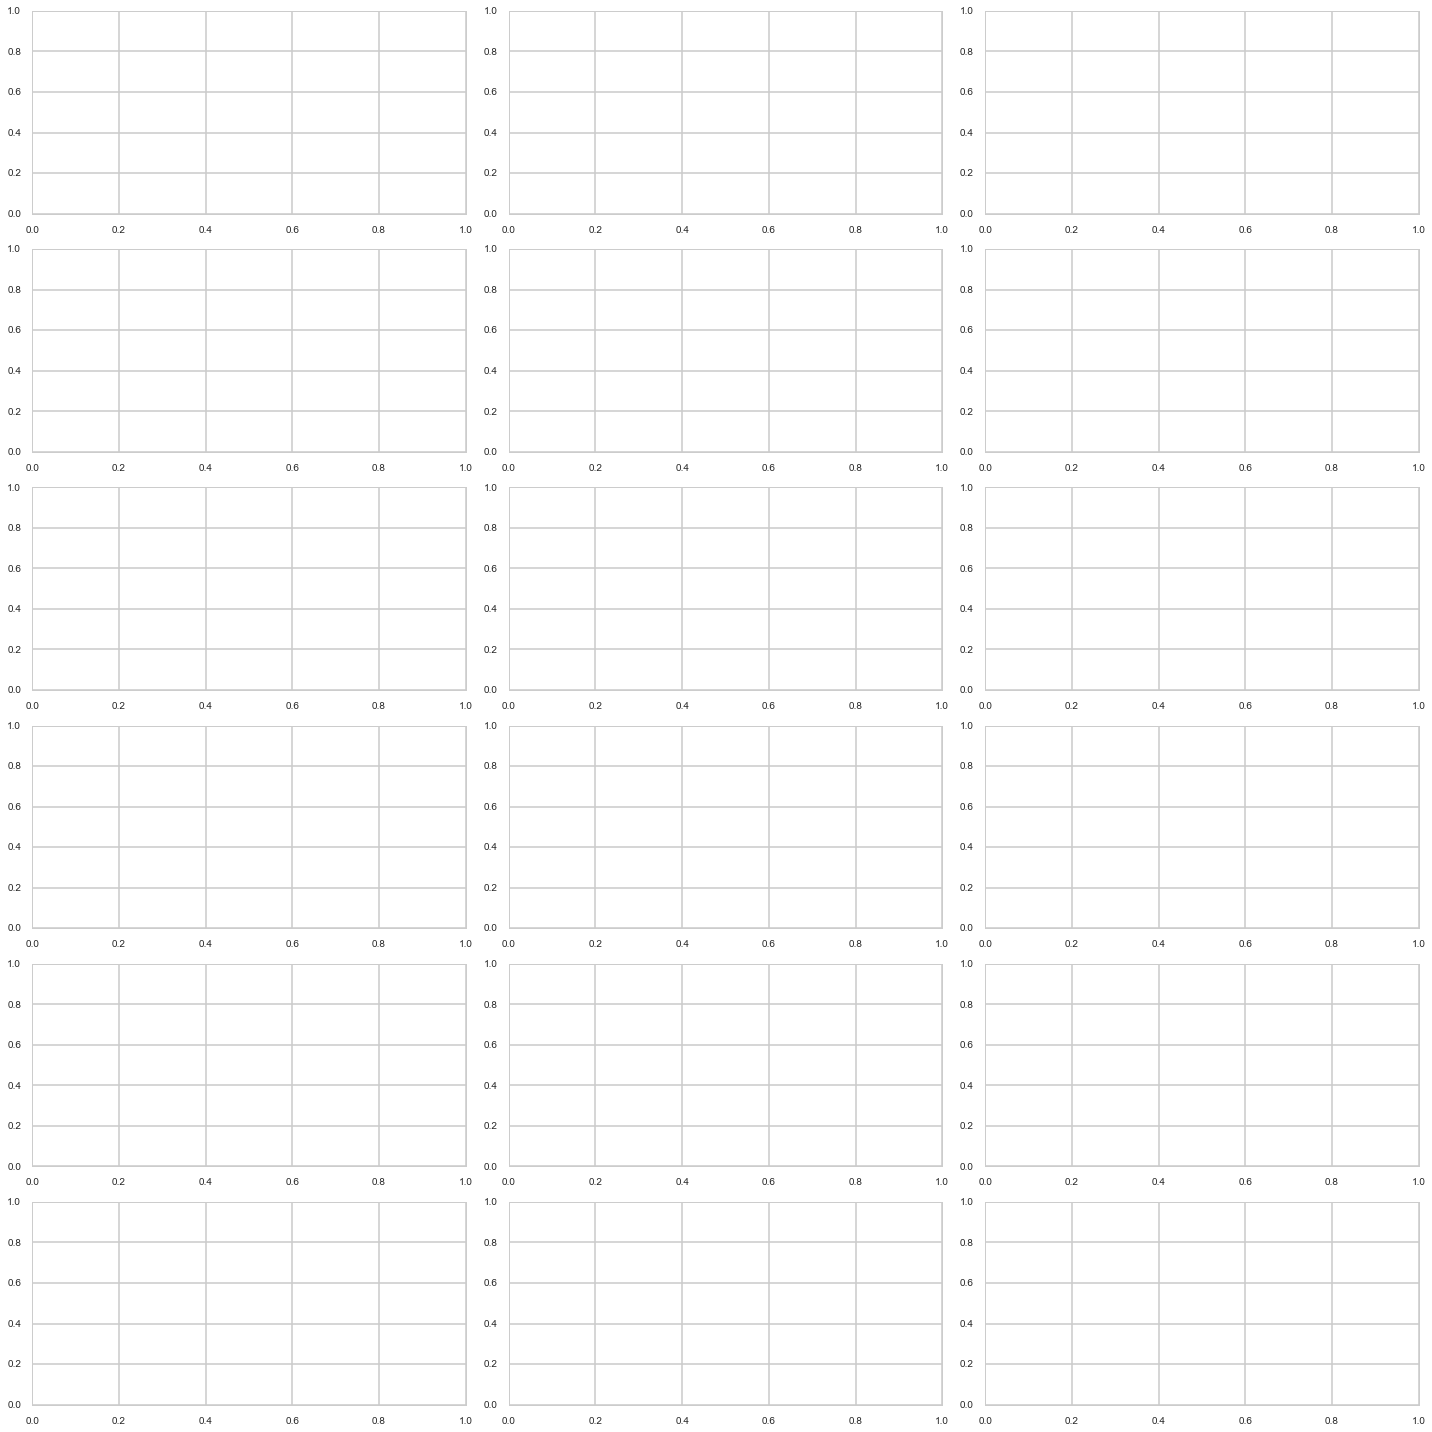

In [176]:
fig1, axes1 = plt.subplots(6,3,tight_layout=True,figsize=(20,20))

df_ir = df_new[df_new['region']=='Iringa']

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for j, variable in enumerate(CATEGORICAL):
    ax1 = axes1[j/3,j%3]
    functional = df_ir[df_ir['status_group']=='functional'][variable].tolist()
    non_functional = df_ir[df_ir['status_group']=='non functional'][variable].tolist()
    needs_repair = df_ir[df_ir['status_group']=='functional needs repair'][variable].tolist()
    categories = pd.Series(df_ir[variable].values.ravel()).unique()
    value_freq_funct = []
    value_freq_nonf = []
    value_freq_repair = []
    categories_num = range(1,len(categories)+1)
    for value in categories:
        value_freq_funct.append(functional.count(value))
        value_freq_nonf.append(non_functional.count(value))
        value_freq_repair.append(needs_repair.count(value))
    ax1.bar(categories_num,value_freq_funct,align='center',color='limegreen')
    ax1.bar(categories_num,value_freq_nonf,align='center',color='r')
    ax1.bar(categories_num,value_freq_repair,align='center',color='b')
    ax1.set_xticks(categories_num)
    ax1.set_xticklabels(categories,ha='right',rotation=40)
    ax1.legend(markers,use_colors.keys(),loc='best',fontsize='8')
    ax1.set_title(variable)

plt.show()

In [186]:
CATEGORICAL

[u'funder',
 u'installer',
 u'basin',
 u'public_meeting',
 u'scheme_management',
 u'permit',
 u'extraction_type_group',
 u'extraction_type_class',
 u'management',
 u'management_group',
 u'payment_type',
 u'water_quality',
 u'quantity',
 u'source_type',
 u'source_class',
 u'waterpoint_type_group',
 u'date_recorded_month',
 u'region']